# System identification of Lindblad master equation

In [215]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv, norm
from qutip import rand_herm, rand_dm, mesolve, Qobj

from ncpol2sdpa import generate_variables, SdpRelaxation
from sympy import Matrix, I, eye, re, im, diag, solve

# utilities

In [216]:
def unknown_complex_matrix(name, n):
    return Matrix(n, n, generate_variables('Re' + name, n * n)) \
        + I * Matrix(n, n, generate_variables('Im' + name, n * n))

In [217]:
def unknown_real_matrix(name, n):
    return Matrix(n, n, generate_variables(name, n * n))

In [218]:
def unknown_hermitian_matrix(name, n):
    
    x = generate_variables(name, n ** 2)
    M = diag(*x[:n])
    M /= 2
    x = x[n:]

    for i in range(n - 1):
        for j in range(i + 1, n):
            M[i, j] = x.pop() + I * x.pop()
            
    M += M.H
    
    return M

# Generate data

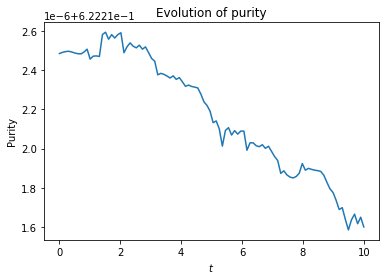

In [219]:
H_exact = rand_herm(2)
A_exact = 0 * rand_herm(2) 

results = mesolve(H_exact, rand_dm(2), np.linspace(0, 10, 100), [A_exact])
# Comvert states to numpy array
rho = [_.data.toarray() for _ in results.states]

plt.title("Evolution of purity")
plt.plot(results.times, [_.purity() for _ in results.states])
plt.xlabel('$t$')
plt.ylabel('Purity')
plt.show()

In [220]:
H_exact * A_exact - A_exact * H_exact

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 0.]]

# Define objective function

In [221]:
H = unknown_hermitian_matrix('H', 2)
A = 0 * unknown_hermitian_matrix('A', H.shape[0])

def rhs(rho):
    """
    Right hand side of the Lindblad master equation
    """
    return -I * (H @ rho - rho @ H) \
        + A @ rho @ A.H - (A.H @ A @ rho + rho @ A.H @ A) / 2

In [222]:
# the density matrix integrated over time
int_rho = np.trapz(
    rho,
    x=results.times,
    axis=0
)

In [223]:
obj = (rho[-1] - rho[0] - rhs(int_rho)).norm() ** 2
obj = re(obj.simplify())

## Check that the exact solution zeros the objective function

In [224]:
exact_solution = solve(H - H_exact) 
#exact_solution.update(solve(A - A_exact))
#exact_solution = solve(A - A_exact)
obj.subs(exact_solution)

1.11429543414587e-6

In [225]:
level = 2

sdp = SdpRelaxation(list(obj.free_symbols))
sdp.get_relaxation(level, objective=obj)
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    solution = {var: sdp[var] for var in sdp.variables}
else:
    solution = None

In [226]:
obj.subs(solution)

2.89956836319050e-10

In [227]:
H.subs(solution)

Matrix([
[                   -0.00012630441349454, 0.122239072819451 + 0.019665955970448*I],
[0.122239072819451 - 0.019665955970448*I,                    -0.00445937662834058]])

In [228]:
H_exact

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[-0.93485182+0.j          0.29987414-0.52039106j]
 [ 0.29987414+0.52039106j  0.        +0.j        ]]

# Second cost function

In [229]:
obj = 0

for t in range(2, len(rho) + 1):
    # the density matrix integrated over time
    int_rho = np.trapz(
        rho[:t],
        x=results.times[:t],
        axis=0
    )
    
    obj += (rho[t - 1] - rho[0] - rhs(int_rho)).norm() ** 2

obj = re(obj.simplify())

## Check that the exact solution zeros the objective function

In [230]:
obj.subs(exact_solution)

5.73117439301996e-5

In [231]:
level = 2

sdp = SdpRelaxation(list(obj.free_symbols))
sdp.get_relaxation(level, objective=obj)
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    solution = {var: sdp[var] for var in sdp.variables}
else:
    solution = None

In [232]:
obj.subs(solution)

1.36152777940879e-9

In [233]:
solution

{H2: -0.521419741411833,
 H1: 0.478852150398684,
 H3: 0.3004683143171373,
 H0: -0.4578483112188852}

In [239]:
H.subs(solution)

Matrix([
[                     -0.460386106994832, 0.299516204205339 - 0.521487106978261*I],
[0.299516204205339 + 0.521487106978261*I,                       0.462734519656319]])

# Objective function inspired by implicit Euler method

In [234]:
dt = results.times[1] - results.times[0]

obj = 0

for t in range(1, len(rho)):
    
    obj += (rho[t] - rho[t - 1] - dt * rhs(rho[t])).norm() ** 2

obj = re(obj.simplify())

## Check that the exact solution zeros the objective function

In [235]:
obj.subs(exact_solution)

0.00105128314387846

In [236]:
level = 4

sdp = SdpRelaxation(list(obj.free_symbols))
sdp.get_relaxation(level, objective=obj)
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    solution = {var: sdp[var] for var in sdp.variables}
else:
    solution = None

In [237]:
obj.subs(solution)

0.00103929465637209

In [238]:
solution

{H2: -0.5214871069782613,
 H1: 0.46273451965631923,
 H3: 0.29951620420533903,
 H0: -0.4603861069948322}

# Vectorization

In [ ]:
G = unknown_complex_matrix('G', H.shape[0] * H.shape[1])
e = eye(H.shape[0] * H.shape[1])

obj = 0

for t in range(1, len(rho)):
    obj += (
        Matrix(rho[t].reshape(-1))
        - G @ Matrix(rho[t-1].reshape(-1))
    ).norm() ** 2

obj = re(obj.simplify())

In [ ]:
level = 1

sdp = SdpRelaxation(list(obj.free_symbols))
sdp.get_relaxation(level, objective=obj)
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    solution = {var: sdp[var] for var in sdp.variables}
else:
    solution = None

In [ ]:
obj.subs(solution)

In [ ]:
g = np.array(G.subs(solution), np.complex)

In [ ]:
np.abs(g @ g.conj().T)

In [ ]:
np.abs(g.conj().T - g)